# Table of Contents
 <p><div class="lev1"><a href="#Scoring"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scoring</a></div><div class="lev2"><a href="#Train-test-split"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train test split</a></div><div class="lev2"><a href="#Fit"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Fit</a></div><div class="lev2"><a href="#Predict"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Predict</a></div><div class="lev2"><a href="#Score"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Score</a></div><div class="lev2"><a href="#Logloss"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Logloss</a></div><div class="lev2"><a href="#Confusion-Matrix"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Confusion Matrix</a></div><div class="lev1"><a href="#Cross-validation"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cross validation</a></div><div class="lev2"><a href="#Train-testsplit"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train testsplit</a></div><div class="lev2"><a href="#Cross-val-score"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Cross val score</a></div><div class="lev1"><a href="#Optimal-parameters-search"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimal parameters search</a></div><div class="lev2"><a href="#GridSearchCV"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>GridSearchCV</a></div><div class="lev2"><a href="#Predict-with-best-estimator"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Predict with best estimator</a></div><div class="lev1"><a href="#Overfitting-and-underfitting-detection"><span class="toc-item-num">4&nbsp;&nbsp;</span>Overfitting and underfitting detection</a></div><div class="lev2"><a href="#Learning-curve"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Learning curve</a></div><div class="lev2"><a href="#Validation-Curve"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Validation Curve</a></div>

In [22]:
# %load load_and_enrich.py
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

#load csv
%time train = pd.read_csv(r'data/train.csv', parse_dates=['Dates'])
%time test = pd.read_csv(r'data/train.csv', parse_dates=['Dates'])
%time sample = pd.read_csv(r'data/sampleSubmission.csv')

#Enrichment function
def enrich(df):
    # Some extra columns
    df['Hour'] = df.Dates.dt.hour
    df['Year'] = df.Dates.dt.year
    df['Month'] = df.Dates.dt.month
    df['DayOfWeek'] = df.Dates.dt.dayofweek
    df['Day'] = df.Dates.dt.day
    
%time enrich(train)
%time enrich(test)



Wall time: 4.36 s
Wall time: 4.38 s
Wall time: 5.07 s
Wall time: 1.36 s
Wall time: 1.38 s


In [23]:
# %load prepare_data_for_sklearn.py
#Adapt Data for Scikit Learn model fitting and predict
def prepare_data_for_sklearn(df, is_test=False):
    x_columns = ['Hour','Month','Year','X','Y','DayOfWeek']
    y_column = 'Category'   
    #x_categorical_columns = ['']
       #x_columns.extend(x_categorical_columns)
    
    X = df[x_columns]
    #if len(x_categorical_columns)>0:
       # X = pd.get_dummies(X, columns=x_categorical_columns)
    
    y = None if is_test else df[y_column].values
    
    return X, y
%time X,y = prepare_data_for_sklearn(train)
%time X_test,dummy = prepare_data_for_sklearn(test,is_test=True)

Wall time: 95 ms
Wall time: 78 ms


# Scoring

## Train test split

Let's split our train data in two

In [24]:
from sklearn.cross_validation import train_test_split
%time X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.3)
X_train.head()

Wall time: 2.01 s


,Hour,Month,Year,X,Y,DayOfWeek
723546,22,2,2005,-122.419658,37.764221,3
603364,21,10,2006,-122.390953,37.738663,4
50051,9,9,2014,-122.419672,37.765050,1
326756,19,11,2010,-122.423413,37.795737,3
821789,0,10,2003,-122.413711,37.779666,3


In [25]:
print("Number of sample in test: %d" % len(X_test))
print("Number of sample in train: %d" % len(X_train))
print("Computed Ratio: %f" % (float(len(X_test))/(len(X_train) + len(X_test))))

Number of sample in test: 263415
Number of sample in train: 614634
Computed Ratio: 0.300000


Now let's create a Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, criterion='gini', min_samples_split=2)

## Fit

And now let's train it

In [27]:
%time rf.fit(X_train,y_train)

Wall time: 52.8 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Predict

And now let's predict on the retained data

In [28]:
%time y_pred = rf.predict(X_test)

Wall time: 14.2 s


## Score

Which score did I achieve on the test fold ?

In [29]:
%time score = rf.score(X_test, y_test)
print("NB SAMPLE TESTED: %d" % len(X_test))
print("GOOD CLASSIFICATIONS: %d" % np.sum(np.equal(y_pred, y_test)))
print("ACURACY: %f" % score)

Wall time: 6.31 s
NB SAMPLE TESTED: 263415
GOOD CLASSIFICATIONS: 70200
ACURACY: 0.266500


Actually Kaggle relies on the log loss. What is my log loss score ?

## Logloss

<img src="img\log_loss.JPG">

In [30]:
%time y_pred_proba = rf.predict_proba(X_test)

Wall time: 4.44 s


In [31]:
from sklearn.metrics import log_loss

%time score = log_loss(y_pred=y_pred_proba, y_true=y_test)
print ("LOG LOSS SCORE: %f" % score)

Wall time: 5.84 s
LOG LOSS SCORE: 14.115617


## Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix

ordered_categories = list(train.Category.value_counts().index)
%time confusion_m = confusion_matrix(y_test, y_pred, ordered_categories)
confusion_m

Wall time: 2.98 s


array([[26470,  5335,  4805, ...,     2,     0,     0],
       [ 6979,  9547,  3078, ...,     6,     2,     0],
       [ 8353,  3754,  5261, ...,     0,     0,     0],
       ..., 
       [    7,     9,     2, ...,     1,     0,     0],
       [    1,     1,     0, ...,     0,     0,     0],
       [    0,     0,     1, ...,     0,     0,     0]])

C:\Users\GRANVILLE\Anaconda2\Lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


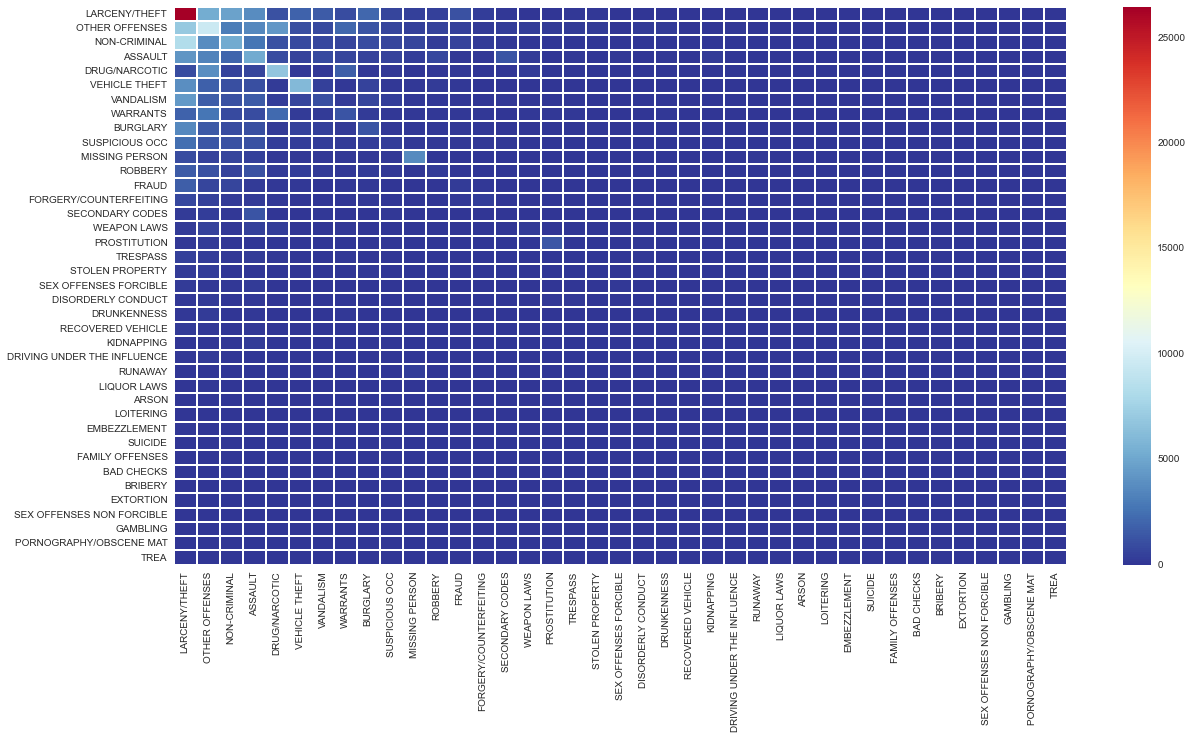

In [33]:
import seaborn as sns
from matplotlib import cm 
plt.figure(figsize=(20,10))
sns.heatmap(confusion_m, linewidths=.5,xticklabels=ordered_categories,yticklabels=ordered_categories,cmap=cm.RdYlBu_r)
plt.show()

# Cross validation

## Train / test  split

In [34]:
%time X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.3)

Wall time: 12 s


## Cross val score

<img src="img\kfold.JPG">

In [35]:
from sklearn.cross_validation import cross_val_score
%time scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='log_loss')
scores

Wall time: 3min 5s


array([-14.33941014, -14.39885413, -14.24989487, -14.35698986, -14.21861215])

In [36]:
print("MEAN %f / STD: %f" % (np.mean(scores) ,np.std(scores)))

MEAN -14.312752 / STD: 0.067668


# Optimal parameters search

Is there a way to find the optimal parameters to get the best possible score ?    
We now define the parameters we want to use for the optimization.

In [71]:
params= [{
    'n_estimators'      : [10],
    'max_depth'         : [1,3,5],
    'min_samples_split' : [2,5],
    'criterion'         : ["entropy", "gini"],
},]

## GridSearchCV

In [52]:
from sklearn.grid_search import GridSearchCV

gs = GridSearchCV(rf, param_grid=params, scoring="log_loss", cv=3)

In [50]:
%time X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

Wall time: 858 ms


In [72]:
%time gs.fit(X_train, y_train);pass

Wall time: 3min 45s


In [73]:
print("Best score %s",gs.best_score_)
print("Best params %s",gs.best_params_)

Best score %s -2.56872625543
Best params %s {'min_samples_split': 2, 'n_estimators': 10, 'criterion': 'gini', 'max_depth': 5}


## Predict with best estimator

In [74]:
best_rf = gs.best_estimator_
y_pred_proba = best_rf.predict_proba(X_test)
print ("LOG LOSS SCORE: %f" % log_loss(y_pred=y_pred_proba, y_true=y_test))

LOG LOSS SCORE: 2.568209


# Overfitting and underfitting detection

## Learning curve

In [75]:
from sklearn.learning_curve import learning_curve
%time train_sizes, train_scores, test_scores = learning_curve(best_rf, X, y, cv=5)

Wall time: 5min 10s


There seems to be a significant bias in our model

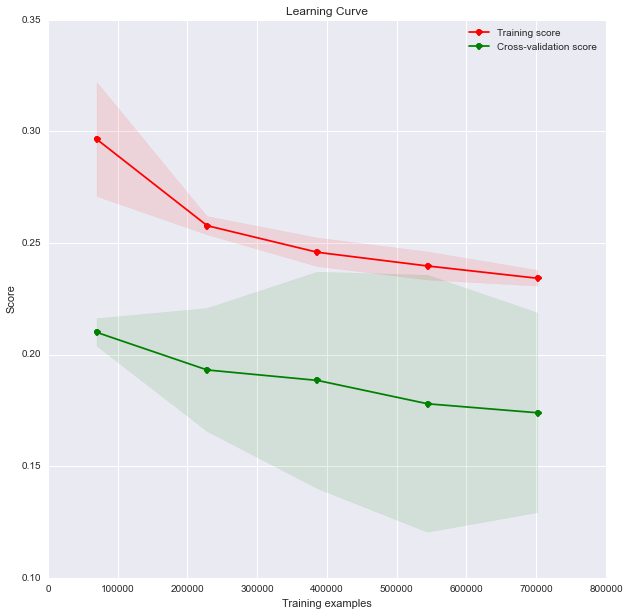

In [76]:
plt.figure(figsize=(10,10))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid(True)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

## Validation Curve

In [77]:
from sklearn.learning_curve import validation_curve

In [78]:
param_name = "max_depth"
param_range =[2,5,10,15]

In [80]:
%time train_scores, test_scores = validation_curve(rf, X, y, param_name=param_name, param_range=param_range,cv=5, scoring="log_loss")

Wall time: 11min 18s


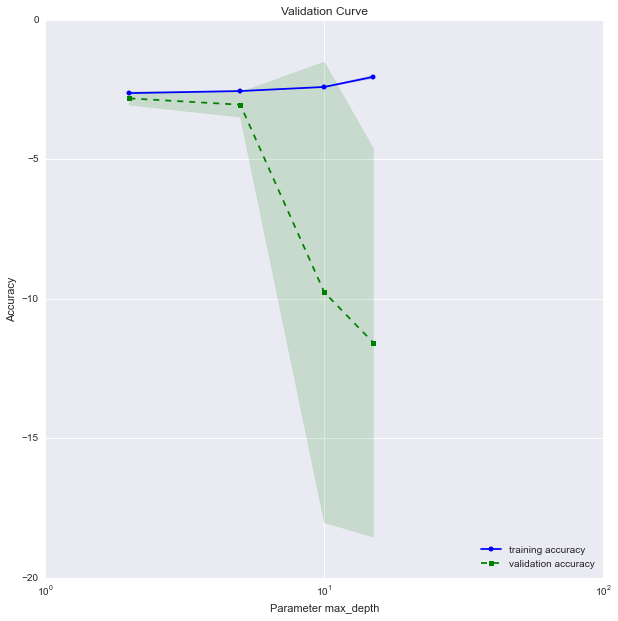

In [81]:
plt.figure(figsize=(10,10))
plt.title("Validation Curve")

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid(True)
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter max_depth')
plt.ylabel('Accuracy')
plt.show()

In [82]:
%load_ext version_information
%version_information numpy,pandas,matplotlib,sklearn,seaborn

Software versions
Python 2.7.11 64bit [MSC v.1500 64 bit (AMD64)]
IPython 4.0.0
OS Windows 10 10.0.10586
numpy 1.11.0
pandas 0.17.0
matplotlib 1.4.3
sklearn 0.17.1
seaborn 0.7.0
Tue May 31 08:19:53 2016 GMT Daylight Time